## Available implementations
Simple message passing


$Y = \sigma(\Theta X^T A +b) $ 


- Input feature vectors $X \in \R^{n, d}$ , $n$ samples/patients/nodes, $d$ features
- Fully connected  layer: weights $\Theta \in \R^{h, d}$ , biases $b\in \R^{h}$
- $A \in \R^{n, n}$ normalized adjacency matrix 
- $\sigma$ non linearity
- $Y \in R^{h, n}$ hidden vector.


# Graph convolutions
### Analogy with Non Local Means
Let's take a regular grid (image pixels) and define it as a graph.
For instance, a pixel can have a 4 (cross neighborhood) or a 9 (cross+diagonals) neighborhood... or simply more like the whole image.
Node features are colors or gray levels.
One can define similarity between gray levels in the graph weights (like similarity between patient)  

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np


In [2]:
# h, w = 8, 8
# img = torch.zeros(3, h, w)
# img[0, :h//2, :w//2] = 0.5
# img[:, h//2:, :w//2] = 0.5
# img[2, h//2:, w//2:] = 0.5
# img[1, :h//2, w//2:] = 0.5
# sigma = 0.05
# img_noisy = img + torch.randn(3, h, w) * sigma
# plt.imshow(img_noisy.permute(1, 2, 0))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


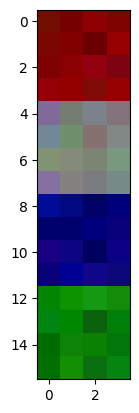

In [3]:
w = 4
n = 4
h = n*w
img = torch.zeros(3, h, w)
img[0, :h//n, :] = 0.5
img[:, h//n:2*h//n, :] = 0.5
img[2, 2*h//n:3*h//n:, :] = 0.5
img[1, 3*h//n:, :] = 0.5
sigma = 0.05
img_noisy = img + torch.randn(3, h, w) * sigma
plt.imshow(img_noisy.permute(1, 2, 0))

In [4]:
coords = torch.meshgrid(torch.arange(h), torch.arange(w))
coords = torch.vstack([coords[0].reshape(-1), coords[1].reshape(-1)])
coords= coords.to(torch.float32)


/home/bneveu/.local/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3491.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [5]:
distance = torch.cdist(coords.t(), coords.t(), p=2)


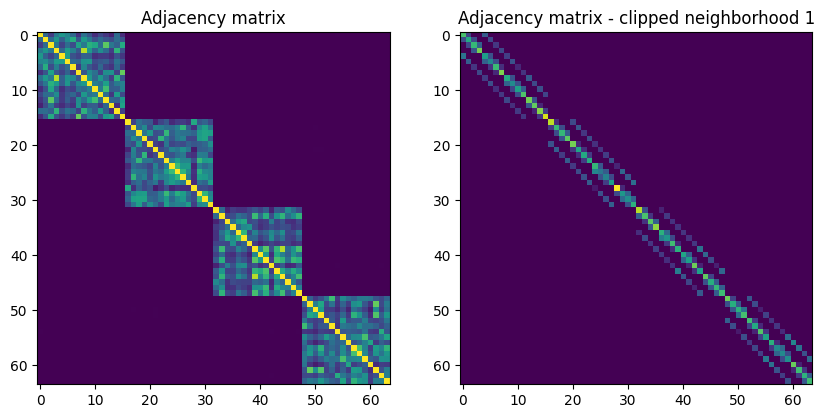

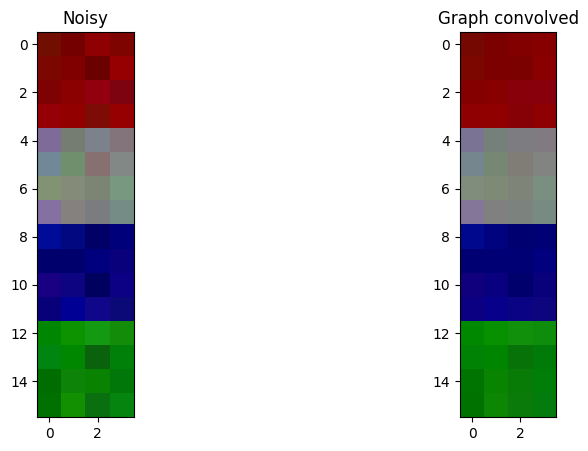

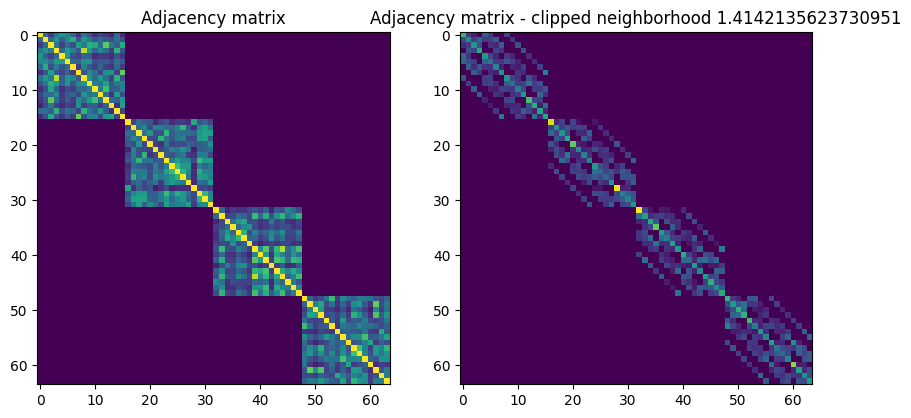

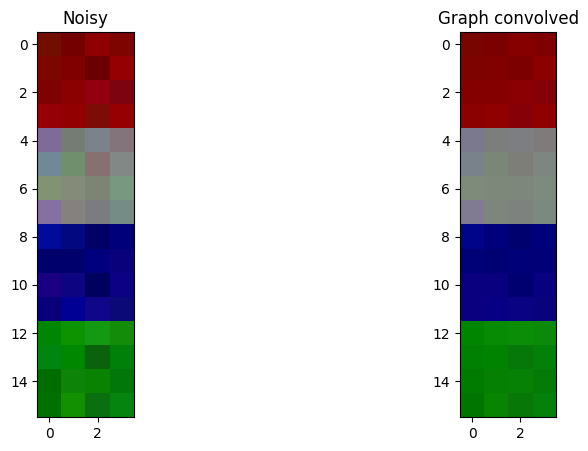

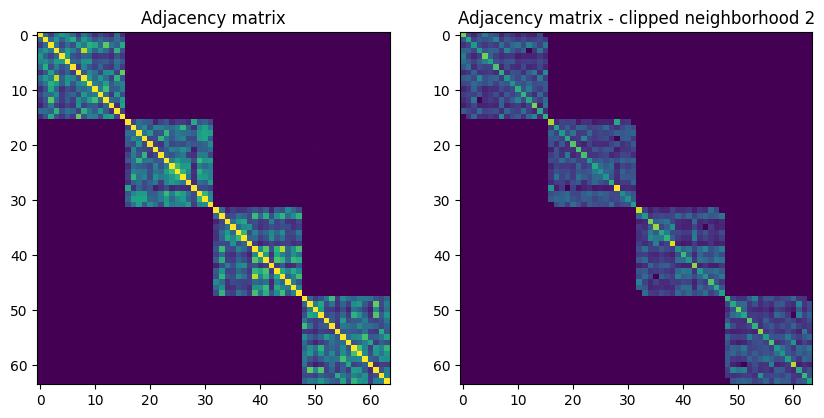

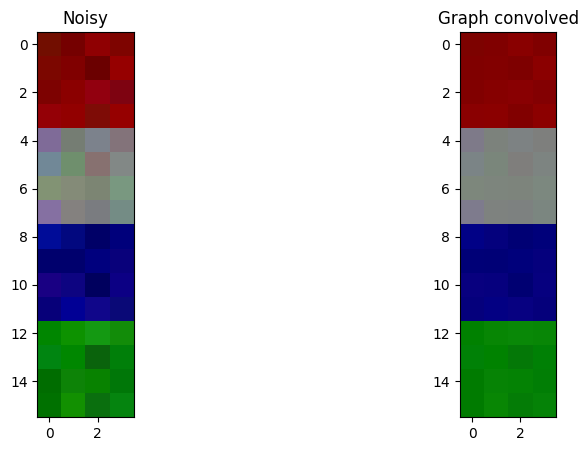

In [6]:
for dist in [1, np.sqrt(2), 2]:
    x = img_noisy.view(img_noisy.shape[0], -1)
    adj = torch.cdist(x.t(), x.t(), p=2)
    sigma=0.1
    adj = torch.exp(-adj/(sigma))
    adj_norm = adj*(distance<=dist**2)
    # adj_norm = adj
    adj_norm = adj_norm / adj_norm.sum(dim=0)

    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    axs[0].imshow(adj)
    axs[0].set_title("Adjacency matrix")
    axs[1].imshow(adj_norm.clip(0, 1))
    axs[1].set_title(f"Adjacency matrix - clipped neighborhood {dist}")
    plt.show()

    x_filtered = x@adj_norm
    x_filtered.shape

    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    axs[0].imshow(img_noisy.permute(1, 2, 0).clip(0, 1.))
    axs[0].set_title("Noisy")
    axs[1].imshow(x_filtered.reshape(3, h, w).permute(1, 2, 0).clip(0, 1.))
    axs[1].set_title("Graph convolved")

    plt.show()



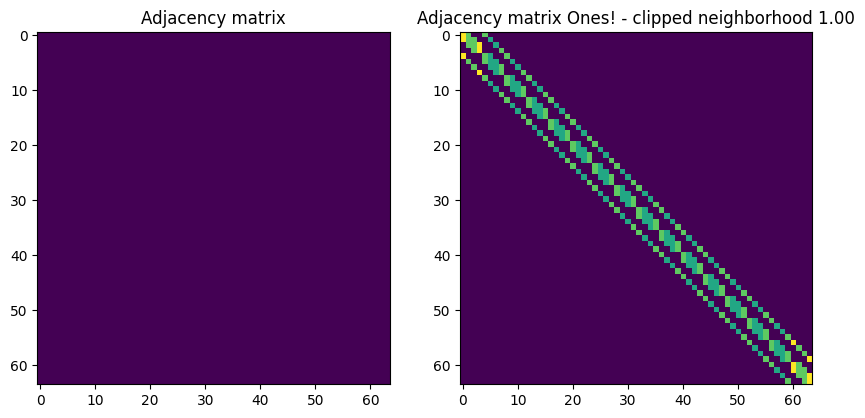

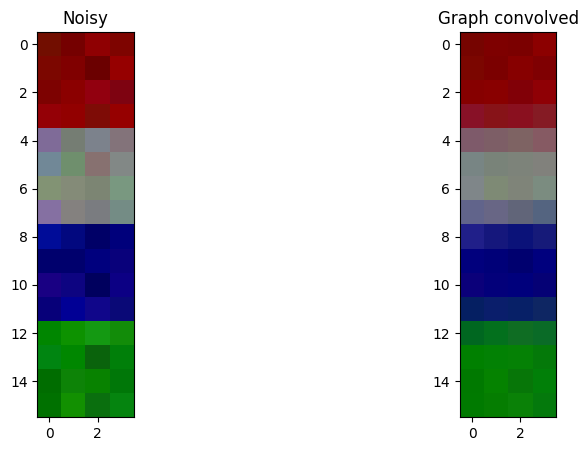

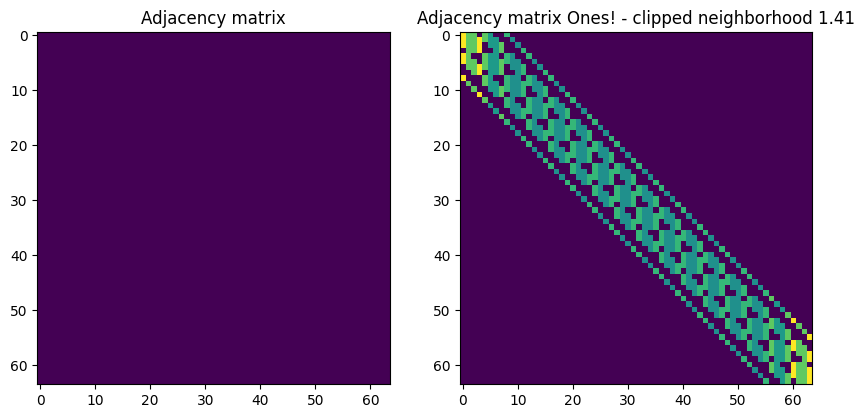

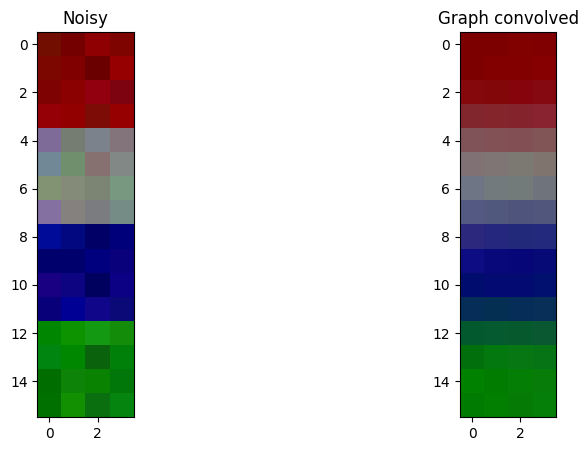

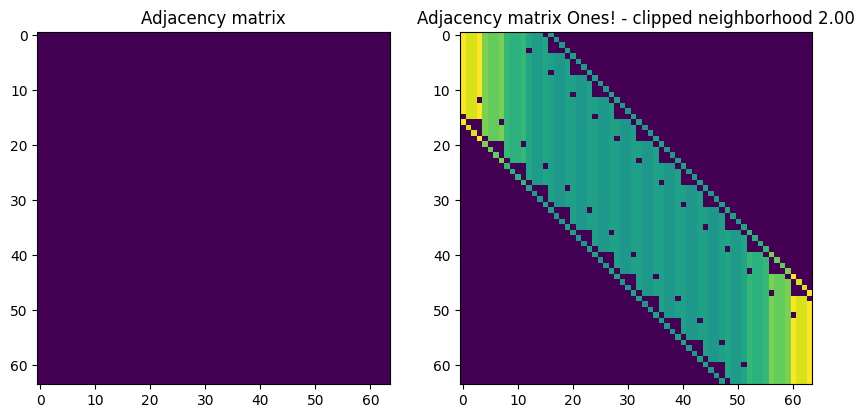

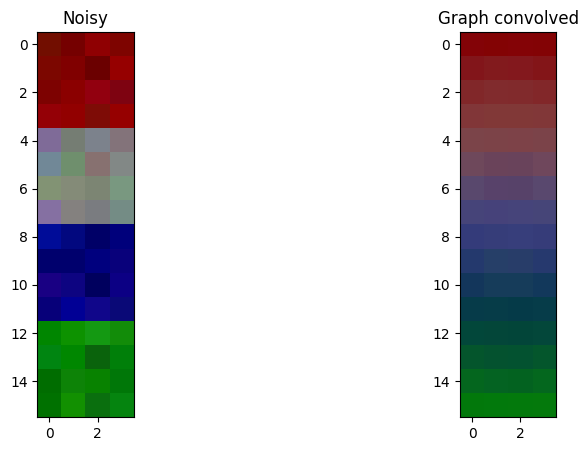

In [7]:
for dist in [1, np.sqrt(2), 2]:
    x = img_noisy.view(img_noisy.shape[0], -1)
    adj = torch.ones(x.shape[1], x.shape[1])
    adj = torch.exp(-adj/(sigma))
    adj_norm = adj*(distance<=dist**2)
    # adj_norm = adj
    adj_norm = adj_norm / adj_norm.sum(dim=0)

    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    axs[0].imshow(adj.clip(0, 1))
    axs[0].set_title("Adjacency matrix")
    axs[1].imshow(adj_norm.clip(0, 1))
    axs[1].set_title(f"Adjacency matrix Ones! - clipped neighborhood {dist:.2f}")
    plt.show()

    x_filtered = x@adj_norm
    x_filtered.shape

    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    axs[0].imshow(img_noisy.permute(1, 2, 0).clip(0, 1.))
    axs[0].set_title("Noisy")
    axs[1].imshow(x_filtered.reshape(3, h, w).permute(1, 2, 0).clip(0, 1.))
    axs[1].set_title("Graph convolved")

    plt.show()



# ChebConv


The authors use ChebConv which implies using a polynomial of the normalized laplacian matrix (instead of the adjacency matrix) 

Pytorch geometry implements [ChebConv](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.conv.ChebConv.html) in the case of sparse matrices

- $T_0(x) = 1$
- $T_1(x) = x$
- $T_2(x) = 2x^2 - 1$
- $T_3(x) = 4x^3 - 3x$
- $T_4(x) = 8x^4 - 8x^2 + 1$


In [8]:
def poly_cheb(adj, deg=1):
    lap = torch.eye(adj.shape[0]) - adj
    x = torch.eye(lap.shape[0])
    x_list = [x]
    for i in range(1, deg+1):
        x = 2*lap@x - x_list[i-1]
        x_list.append(x)
    return x_list

poly_cheb(adj_norm, deg=2)


[tensor([[1., 0., 0.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 1., 0., 0.],
         [0., 0., 0.,  ..., 0., 1., 0.],
         [0., 0., 0.,  ..., 0., 0., 1.]]),
 tensor([[ 0.8750, -0.1176, -0.1176,  ...,  0.0000,  0.0000,  0.0000],
         [-0.1250,  0.8824, -0.1176,  ...,  0.0000,  0.0000,  0.0000],
         [-0.1250, -0.1176,  0.8824,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.8824, -0.1176, -0.1250],
         [ 0.0000,  0.0000,  0.0000,  ..., -0.1176,  0.8824, -0.1250],
         [ 0.0000,  0.0000,  0.0000,  ..., -0.1176, -0.1176,  0.8750]]),
 tensor([[ 0.9357, -0.0689, -0.0689,  ...,  0.0000,  0.0000,  0.0000],
         [-0.0732,  0.9477, -0.0602,  ...,  0.0000,  0.0000,  0.0000],
         [-0.0732, -0.0602,  0.9477,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.9477, -0.0602, -0.0732]

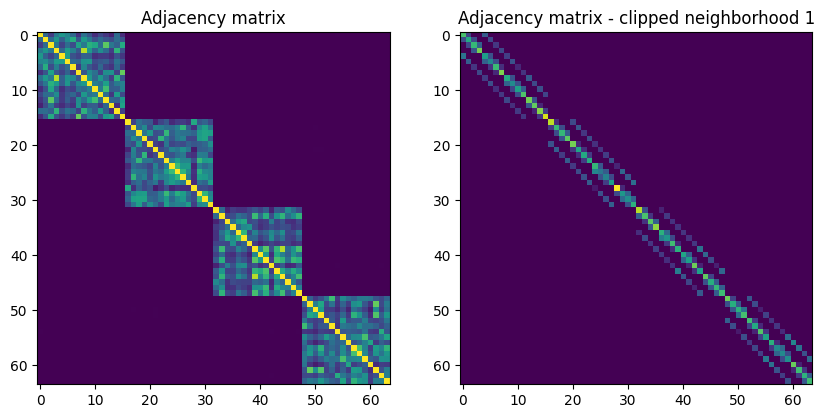

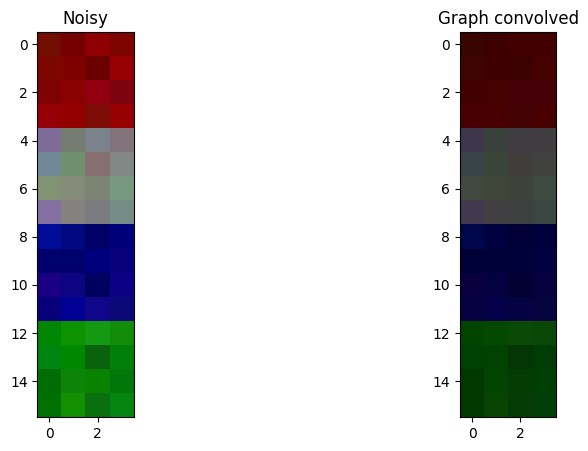

In [9]:
for dist in [1,]:
    x = img_noisy.view(img_noisy.shape[0], -1)
    adj = torch.cdist(x.t(), x.t(), p=2)
    sigma=0.1
    adj = torch.exp(-adj/(sigma))
    adj_norm = adj*(distance<=dist**2)
    adj_norm = adj_norm / adj_norm.sum(dim=0)

    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    axs[0].imshow(adj)
    axs[0].set_title("Adjacency matrix")
    axs[1].imshow(adj_norm.clip(0, 1))
    axs[1].set_title(f"Adjacency matrix - clipped neighborhood {dist}")
    plt.show()

    x_filtered = x@(adj_norm - 0.5*adj_norm@adj_norm)
    x_filtered.shape

    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    axs[0].imshow(img_noisy.permute(1, 2, 0).clip(0, 1.))
    axs[0].set_title("Noisy")
    axs[1].imshow(x_filtered.reshape(3, h, w).permute(1, 2, 0).clip(0, 1.))
    axs[1].set_title("Graph convolved")

    plt.show()

